# Analisi dati

In [1]:
import numpy as np
import math
import sys
import random
import matplotlib.pyplot as plt

In [2]:
R=2
T1=1
T2=2
T3=3
T4=4
T5=10
T6=599

In [3]:
import pandas
df = pandas.read_csv('misure_grezze.csv')

In [4]:
conteggi_t1=df.iloc[0]
conteggi_t2=df.iloc[1]
conteggi_t3=df.iloc[2]
conteggi_t4=df.iloc[3]
conteggi_t10=df.iloc[4]
conteggi_t599=1173
conteggi_t1=np.array(conteggi_t1)
conteggi_t2=np.array(conteggi_t2)
conteggi_t3=np.array(conteggi_t3)
conteggi_t4=np.array(conteggi_t4)
conteggi_t10=np.array(conteggi_t10)
conteggi_t599=np.array(conteggi_t599)

In [5]:
def istogrammi_tentativi(R,T,conteggi,off,bin):
    #istogramma
    l=R*T
    mean=l
    sd=np.sqrt(l)
    plt.hist(conteggi,density=True,bins=bin)
    #funzione
    from scipy.stats import poisson
    
    p=poisson(mu=l)
    x = np.arange(l-3*int(sd),l+3*int(sd))
    plt.plot(x, p.pmf(x), 'bo', ms=4,label='poisson pmf $\lambda$={0:.1f}'.format(l))
    #media e deviazione standard
    plt.hlines(off, mean-sd, mean+sd,
           colors='black', lw=2, label='media $\pm \sigma$')
    plt.plot(mean, off, 'ro', ms=8, label='media')
    plt.title('Istogramma tentativi t={0:.1f}s'.format(T),  fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("probabilità $P(x| P_{\lambda})$", fontsize=16)
    plt.legend( fontsize=10)
    plt.ylim(0, np.max(p.pmf(x))*2)

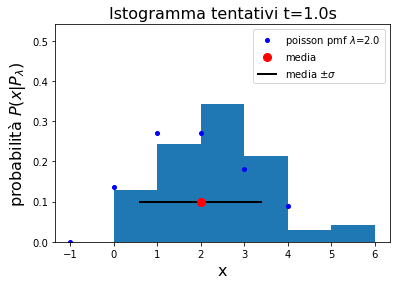

In [6]:
istogrammi_tentativi(R,T1,conteggi_t1,0.1,6)

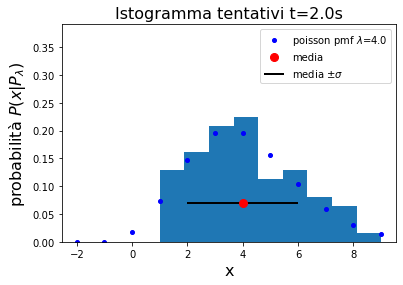

In [7]:
istogrammi_tentativi(R,T2,conteggi_t2,0.07,9)

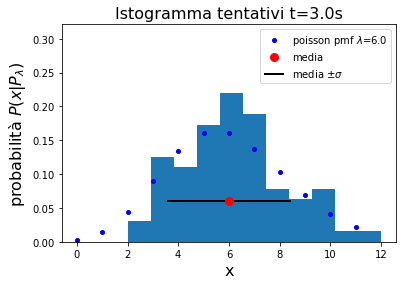

In [8]:
istogrammi_tentativi(R,T3,conteggi_t3,0.06,11)

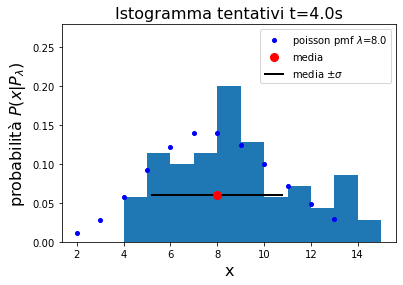

In [9]:
istogrammi_tentativi(R,T4,conteggi_t4,0.06,11)

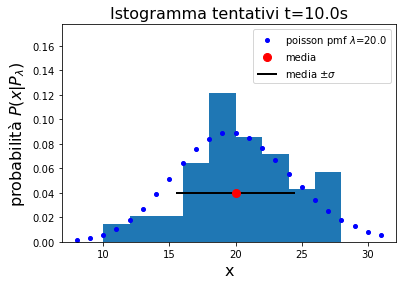

In [10]:
istogrammi_tentativi(R,T5,conteggi_t10,0.04,9)

## inferenza su lamda
prima inferisco e mi trovo la lamda per ogni tempo con la sua incertezza. Per trovare il rate di ogni tempo prendo semplicemente lamda e la divido per t. Per l'inferenza si utilizza la funzione gamma per una combinazione lineare sul numero di conteggi

In [11]:
from scipy.stats import gamma

def inferenza_lamda(conteggi,n_mis,off,T,xlim1,xlim2):
    x=sum(conteggi)
    l = np.linspace(xlim1, xlim2, 300)
    plt.plot(l, gamma.pdf(l, a=x+1, scale=1/n_mis),
             label='$f(\lambda|~\sum x_i=${0:.1f})'.format(x))
    plt.title('Funzione posterior Poissoniana t={0:.1f}s '.format(T), fontsize=16)
    plt.xlabel('$\lambda$',fontsize=16)
    plt.ylim(0, 1.5*max(gamma.pdf(l, a=x+1, scale=1/n_mis)))
    plt.ylabel('$f(\lambda)$',fontsize=16)
    plt.legend(loc='upper right',fontsize=16)
    mean, var = gamma.stats(a=x+1, scale=1/n_mis, moments='mv')
    sd = np.sqrt(var)
    plt.hlines(off, mean-sd, mean+sd,
               colors='black', lw=2,
               label='$\sigma[\lambda]=${0:.2f}'.format(sd))
    plt.plot(mean, off, 'ro', ms=4,
             label='E[$\lambda$]={0:.2f}'.format(mean))
    plt.legend(loc='upper right',fontsize=11)
    return mean,sd

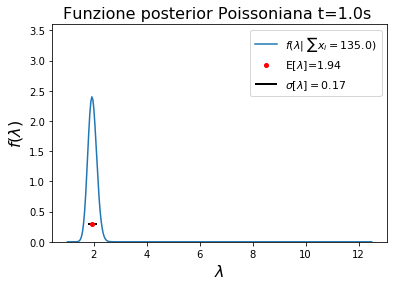

In [12]:
mean1,sd1=inferenza_lamda(conteggi_t1,70,0.3,T1,1,12.5)

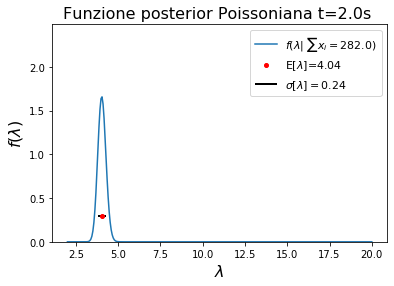

In [13]:
mean2,sd2=inferenza_lamda(conteggi_t2,70,0.3,T2,2,20)

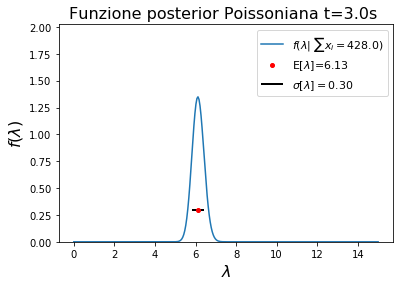

In [14]:
mean3,sd3=inferenza_lamda(conteggi_t3,70,0.3,T3,0,15)

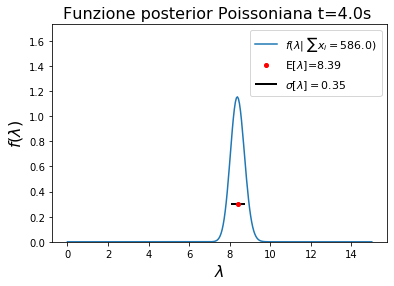

In [15]:
mean4,sd4=inferenza_lamda(conteggi_t4,70,0.3,T4,0,15)

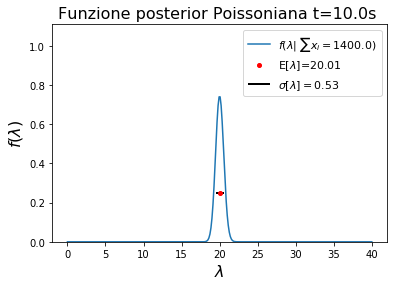

In [16]:
mean5,sd5=inferenza_lamda(conteggi_t10,70,0.25,T5,0,40)

per trovare il valore Rbest con relativa incertezza un metodo potrebbe essere la media pesata sui tempi. Non sono sicuro, correggetemi se sbaglio. ATTENZIONE! I DATI SONO QUELLI DEGLI ISTOGRAMMI PASSATI, IN FOTO.

 RT(tot) = R1*T1 + R2*T2 +...+Rn*Tn = lamda1 + ... + lamda.n

In [17]:
conteggi_tot=sum(conteggi_t1)+sum(conteggi_t2)+sum(conteggi_t3)+sum(conteggi_t4)+sum(conteggi_t10)
Ttot=1+2+3+4+10
mean, var = gamma.stats(a=conteggi_tot+1, scale=1/70, moments='mv')
mu_Rbest=mean/Ttot
sigma_Rbest = np.sqrt(var)/Ttot

In [18]:
mu_Rbest,sigma_Rbest

(2.0228571428571427, 0.038011813416143056)

## verosimiglianza di R per t=1, t=4, t=599 

In [19]:
def inferenza_R(conteggi,n_mis,off,T,xlim1,xlim2):
    x=sum(conteggi)
    R = np.linspace(xlim1, xlim2, 300)
    plt.plot(R, gamma.pdf(R*T, a=x+1, scale=1/n_mis)*T,
             label='f(R|$~\sum x_i$={0:.1f},T)'.format(x))
    plt.title('Funzione verosimiglianza rate t={0:.1f}s '.format(T), fontsize=16)
    plt.xlabel('R',fontsize=16)
    plt.ylim(0, 1.5*max(gamma.pdf(R*T, a=x+1, scale=1/n_mis)*T))
    plt.ylabel('f(R)',fontsize=16)
    plt.legend(loc='upper right',fontsize=16)
    mean, var = gamma.stats(a=x+1, scale=1/n_mis, moments='mv')
    mean=mean/T
    sd = np.sqrt(var)/T
    plt.hlines(off, mean-sd, mean+sd,
               colors='black', lw=2,
               label='sigma[R]={0:.3f}'.format(sd))
    plt.plot(mean, off, 'ro', ms=4,
             label='E[R]={0:.3f}'.format(mean))
    plt.legend(loc='upper right',fontsize=11)
    return mean,sd

In [20]:
def inferenza_R599(conteggi,n_mis,off,T,xlim1,xlim2):
    x=conteggi
    R = np.linspace(xlim1, xlim2, 300)
    plt.plot(R, gamma.pdf(R*T, a=x+1, scale=1/n_mis)*T,
             label='f(R|$~\sum x_i$={0:.1f},T)'.format(x))
    plt.title('Funzione verosimiglianza rate t={0:.1f}s '.format(T), fontsize=16)
    plt.xlabel('R',fontsize=16)
    plt.ylim(0, 1.5*max(gamma.pdf(R*T, a=x+1, scale=1/n_mis)*T))
    plt.ylabel('f(R)',fontsize=16)
    plt.legend(loc='upper right',fontsize=16)
    mean, var = gamma.stats(a=x+1, scale=1/n_mis, moments='mv')
    mean=mean/T
    sd = np.sqrt(var)/T
    plt.hlines(off, mean-sd, mean+sd,
               colors='black', lw=2,
               label='sigma[R]={0:.3f}'.format(sd))
    plt.plot(mean, off, 'ro', ms=4,
             label='E[R]={0:.3f}'.format(mean))
    plt.legend(loc='upper right',fontsize=11)
    return mean,sd

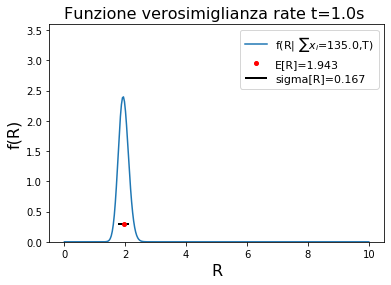

In [21]:
R1,sigma_R1=inferenza_R(conteggi_t1,70,0.3,T1,0,10)

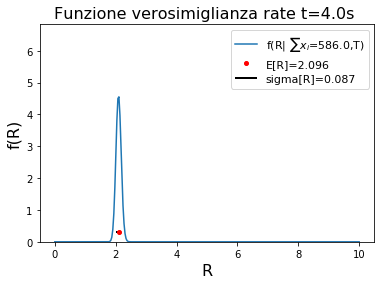

In [22]:
R4,sigma_R4=inferenza_R(conteggi_t4,70,0.3,T4,0,10)

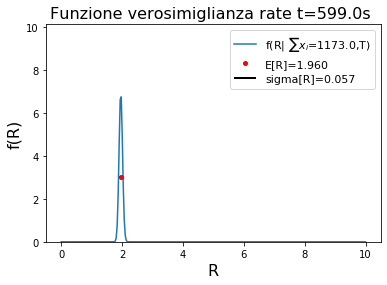

In [23]:
R599,sigmaR599=inferenza_R599(conteggi_t599,1,3,T6,0,10)

inferenza su R per la combinazione di tutte le misure

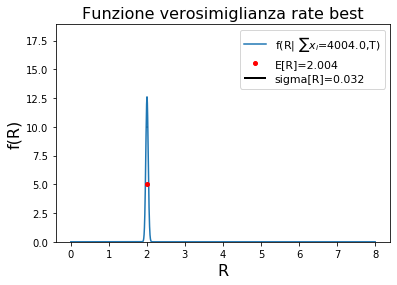

In [24]:
conteggi_tot=sum(conteggi_t1)+sum(conteggi_t2)+sum(conteggi_t3)+sum(conteggi_t4)+sum(conteggi_t10)+conteggi_t599
Ttot=1+2+3+4+10+599/70
R=np.linspace(0,8,100000)
y=gamma.pdf(R*Ttot,a=conteggi_tot+1, scale=1/70)*Ttot
plt.plot(R,y,
    label='f(R|$~\sum x_i$={0:.1f},T)'.format(conteggi_tot))
plt.title('Funzione verosimiglianza rate best', fontsize=16)
plt.xlabel('R',fontsize=16)
plt.ylim(0, 1.5*max(gamma.pdf(R*Ttot, a=conteggi_tot+1, scale=1/70)*Ttot))
plt.ylabel('f(R)',fontsize=16)
plt.legend(loc='upper right',fontsize=16)
mean, var = gamma.stats(a=conteggi_tot+1, scale=1/70, moments='mv')
mean=mean/Ttot
sd = np.sqrt(var)/Ttot
plt.hlines(10, mean-sd, mean+sd,
               colors='black', lw=2,
               label='sigma[R]={0:.3f}'.format(sd))
plt.plot(mean, 5, 'ro', ms=4,
             label='E[R]={0:.3f}'.format(mean))
plt.legend(loc='upper right',fontsize=11)

confronto tra gli istogrammi delle misure e i grafici con incertezze di R quello vero

In [25]:
R=2.004

In [80]:
import numpy as np
import math
import sys
import random
import matplotlib.pyplot as plt

In [81]:
from scipy.stats import poisson
def PrevisionePossion(Lambda,xmin,xmax,n,a):
    x = np.arange(xmin,xmax,a)
    k_list = [] 
    sigma_k_list = []
    for i in x:
        p_i = poisson.pmf(i, Lambda)
        k_list.append( n*p_i )
        sigma_k_list.append( math.sqrt( n * p_i * (1-p_i) ) )  
    k = np.asarray(k_list)
    sigma_k = np.asarray(sigma_k_list)
    return k, sigma_k

In [82]:
def istogrammi_tentativi_confr(R,T,conteggi,bin,a):
    #istogramma
    l=R*T
    mean=l
    sd=np.sqrt(l)
    plt.hist(conteggi,density=True,bins=bin,color='orange')
    #funzione
    from scipy.stats import poisson
    k,sigma_k=PrevisionePossion(l,int(l-3*sd),int(l+3*sd),70,a)
    k=k/70
    sigma_k=sigma_k/70
    x = np.arange(int(l-3*sd),int(l+3*sd),a)
    plt.errorbar(x,k,yerr=sigma_k,marker= 'o', ms=4,color='green',label='poisson pmf $\lambda$={0:.2f}'.format(l))
    #media e deviazione standard
    plt.title('Confronto istogramma t={0:.1f}s'.format(T),  fontsize=16)
    plt.xlabel("x", fontsize=16)
    plt.ylabel("probabilità $P(x| P_{\lambda})$", fontsize=16)
    plt.legend( fontsize=10)
    plt.ylim(0, np.max(k)*2)

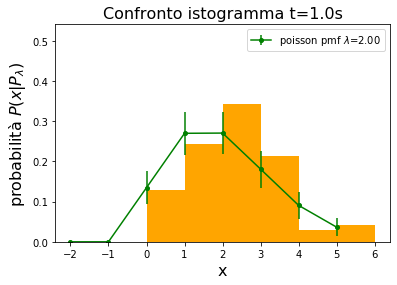

In [83]:
istogrammi_tentativi_confr(R,T1,conteggi_t1,6,1)

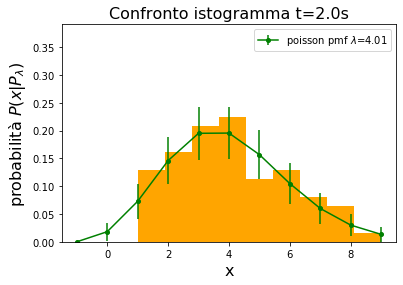

In [84]:
istogrammi_tentativi_confr(R,T2,conteggi_t2,9,1)

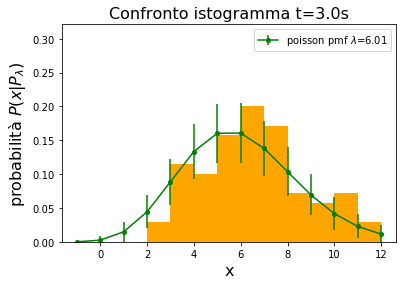

In [85]:
istogrammi_tentativi_confr(R,T3,conteggi_t3,10,1)

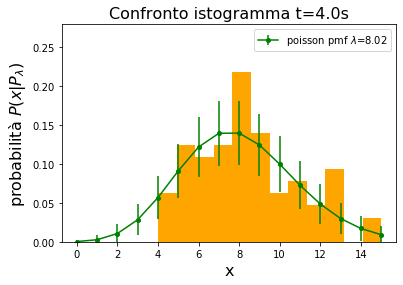

In [86]:
istogrammi_tentativi_confr(R,T4,conteggi_t4,12,1)

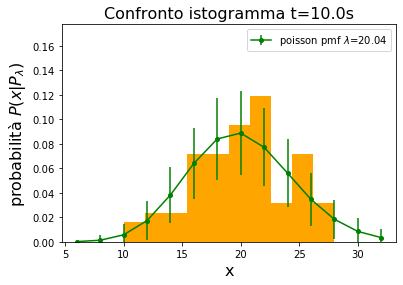

In [101]:
istogrammi_tentativi_confr(R,T5,conteggi_t10,10,2)

## frazioni di 0 conteggi e di 0+1 conteggi
ogni frazione è considerata come una variabile casuale binomiale con probabilità pari alla rispettiva probabilità poissoniana di ottenere 0 o 0+1 conteggio 

In [102]:
cont_0=0
for i in range(0,70):
    if conteggi_t1[i]==0:
        cont_0+=1
frq_0=cont_0/sum(conteggi_t1)

In [103]:
def frac_conteggi0(conteggi,R,T):
    cont_0=0
    for i in range(0,70):
        if conteggi[i]==0:
            cont_0+=1
    frq_0=cont_0/70
    p = poisson.pmf(0, R*T)
    e_frq_0=p
    sigma_frq_0=np.sqrt(70*p*(1-p))/70
    sigB_frq_0=np.sqrt(frq_0*(1-frq_0)/70)
    return e_frq_0,sigma_frq_0,frq_0,sigB_frq_0

In [104]:
E_f1,sig_f1,f1,sigB_f1=frac_conteggi0(conteggi_t1,R,T1)
E_f2,sig_f2,f2,sigB_f2=frac_conteggi0(conteggi_t2,R,T2)
E_f3,sig_f3,f3,sigB_f3=frac_conteggi0(conteggi_t3,R,T3)
E_f4,sig_f4,f4,sigB_f4=frac_conteggi0(conteggi_t4,R,T4)

In [105]:
E_f=[E_f1,E_f2,E_f3,E_f4]
sig_f=[sig_f1,sig_f2,sig_f3,sig_f4]
sigB_f=[sigB_f1,sigB_f2,sigB_f3,sigB_f4]
f=[f1,f2,f3,f4]
t=[1,2,3,4]
E_f=np.array(E_f)
sig_f=np.array(sig_f)
sigB_f=np.array(sigB_f)
f=np.array(f)
t=np.array(t)

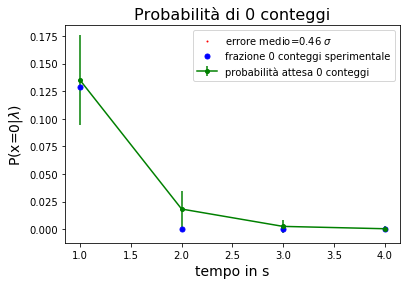

In [106]:
plt.errorbar(t,E_f,yerr=sig_f,marker='o',ms=4,color='green',label='probabilità attesa 0 conteggi')
plt.title('Probabilità di 0 conteggi',fontsize=16)
err_m=np.fabs((E_f-f)/(sig_f)).mean()
plt.plot(t,f,'ro',ms=1,label='errore medio={0:.2f} $\sigma$'.format(err_m))
plt.xlabel('tempo in s',fontsize=14)
plt.ylabel('P(x=0|$\lambda$)',fontsize=14)
plt.plot(t,f,'bo',ms=5,label='frazione 0 conteggi sperimentale')
plt.legend(fontsize=10)

<ErrorbarContainer object of 3 artists>

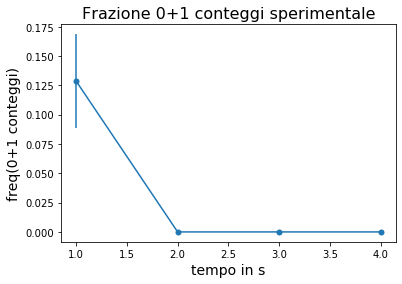

In [107]:
plt.title('Frazione 0+1 conteggi sperimentale',fontsize=16)
plt.xlabel('tempo in s',fontsize=14)
plt.ylabel('freq(0+1 conteggi)',fontsize=14)
plt.errorbar(t,f,yerr=sigB_f,marker='o',ms=5)

In [108]:
def frac_conteggi01(conteggi,R,T):
    cont_0=0
    cont_1=0
    for i in range(0,70):
        if conteggi[i]==0:
            cont_0+=1
        if conteggi[i]==1:
            cont_1+=1
        cont=cont_0+cont_1
    frq_01=cont/70
    p = poisson.pmf(0, R*T)+poisson.pmf(1,R*T)
    e_frq_01=p
    sigB_frq_01=np.sqrt(frq_01*(1-frq_01)/70)
    sigma_frq_01=np.sqrt(70*p*(1-p))/70
    return e_frq_01,sigma_frq_01,frq_01,sigB_frq_01

In [109]:
E_f11,sig_f11,f11,sigB_f11=frac_conteggi01(conteggi_t1,R,T1)
E_f12,sig_f12,f12,sigB_f12=frac_conteggi01(conteggi_t2,R,T2)
E_f13,sig_f13,f13,sigB_f13=frac_conteggi01(conteggi_t3,R,T3)
E_f14,sig_f14,f14,sigB_f14=frac_conteggi01(conteggi_t4,R,T4)

In [110]:
E_f01=[E_f11,E_f12,E_f13,E_f14]
sig_f01=[sig_f11,sig_f12,sig_f13,sig_f14]
sigB_f01=[sigB_f11,sigB_f12,sigB_f13,sigB_f14]
f01=[f11,f12,f13,f14]
t=[1,2,3,4]
E_f01=np.array(E_f01)
sig_f01=np.array(sig_f01)
sigB_f01=np.array(sigB_f01)
f01=np.array(f01)
t=np.array(t)

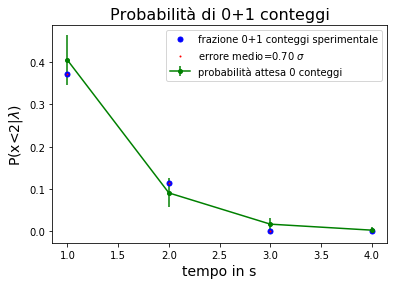

In [112]:
plt.errorbar(t,E_f01,yerr=sig_f01,marker='o',ms=4,color='green',label='probabilità attesa 0 conteggi')
plt.title('Probabilità di 0+1 conteggi',fontsize=16)
plt.xlabel('tempo in s',fontsize=14)
plt.ylabel('P(x<2|$\lambda$)',fontsize=14)
plt.plot(t,f01,'bo',ms=5,label='frazione 0+1 conteggi sperimentale')
err_m1=np.fabs((E_f01-f01)/sig_f01).mean()
plt.plot(t,f01,'ro',ms=1,label='errore medio={0:.2f} $\sigma$'.format(err_m1))
plt.legend(fontsize=10)

Text(0, 0.5, 'freq(0+1 conteggi)')

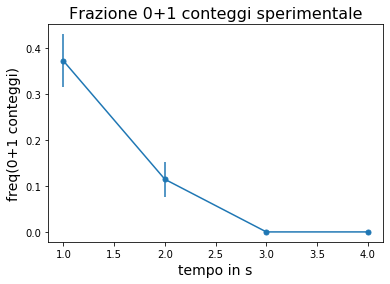

In [115]:
plt.title('Frazione 0+1 conteggi sperimentale',fontsize=16)
plt.errorbar(t,f01,yerr=sigB_f01,marker='o',ms=5)
plt.xlabel('tempo in s',fontsize=14)
plt.ylabel('freq(0+1 conteggi)',fontsize=14)